In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk


#######needed these ones on the first run####
#nltk.download('punkt') 
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('vader_lexicon')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer



from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')
%matplotlib inline
# import a lot of libraries that could be used on the project

In [2]:
# recipes = pd.read_csv('foodcom_with_reviews/recipes.csv')
reviews = pd.read_csv('foodcom_with_reviews/reviews.csv')

In [3]:
# recipes.head(1)

In [4]:
reviews.head(1)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z


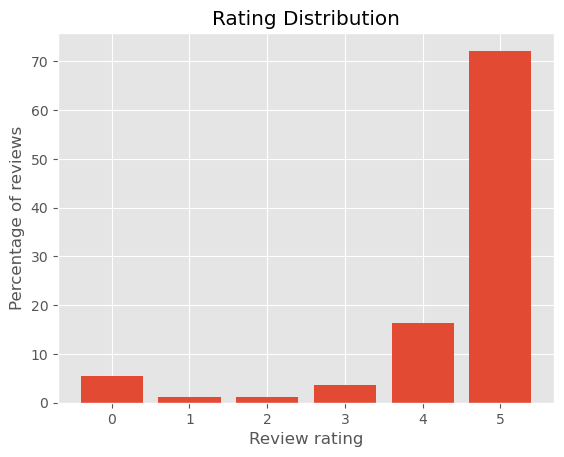

In [5]:
values, counts = np.unique(reviews['Rating'], return_counts = True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('Percentage of reviews')
plt.title('Rating Distribution')
plt.show()

In [6]:
reviews.shape

(1401982, 8)

In [7]:
# dropping reviews that are 3 or 4
reviews = reviews.drop(reviews[(reviews['Rating'] == 3) | (reviews['Rating'] == 4)].index)

I droped reviews that are 3 and 4 because I want to take only extremes to have a better training on if the word is positive or negative. 3 and 4 could be neutral or mixed review which could confuse my model.

In [8]:
reviews['Sentiment'] = np.where(reviews['Rating'] >=4, 1, 0) 
#later replace with reviews_simple or something like that
reviews.head(3)

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z,1
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could taste the cornstarch in the finished product.,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z,0
3,13,7435,1773,Malarkey Test,5,"easily the best i have ever had. juicy flavorful, not dry. the vegetables retain crispness as ...",2000-03-13T21:15:00Z,2000-03-13T21:15:00Z,1


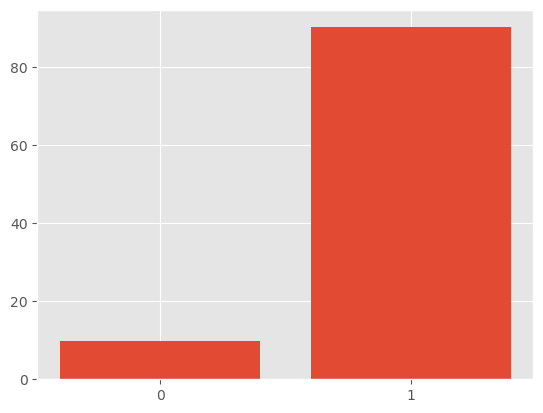

In [9]:
values, counts = np.unique(reviews['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0','1'], normalized_counts*100)
plt.show()

In [10]:
print(values)
print(counts)

[0 1]
[ 110404 1012082]


In [11]:
from sklearn.utils import resample

majority_sentiment = reviews[reviews['Sentiment'] == 1]  # Majority sentiment (positive)
minority_sentiment = reviews[reviews['Sentiment'] == 0]  # Minority sentiment (negative)

# Upsample the minority sentiment
oversampled_minority = resample(minority_sentiment,
                                replace=True,  # Allow duplication
                                n_samples=len(majority_sentiment),  # Match majority sentiment size
                                random_state=42)  # Set a random seed for reproducibility

# Combine the majority sentiment with the oversampled minority sentiment
balanced_reviews = pd.concat([majority_sentiment, oversampled_minority])

# Shuffle the balanced dataset
balanced_reviews = balanced_reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
balanced_reviews.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
0,828167,332723,1204512,sahuston,1,"For me, the receipe was too vague. I did NOT have good results and felt like it was wasted mone...",2009-03-15T19:03:05Z,2009-03-15T19:03:05Z,0
1,2088289,156543,2002083374,Tessa i.,5,These came out perfect. Only used a little over 3 cups. When I had them ready to go on the cooki...,2020-10-23T17:14:26Z,2020-10-23T17:14:26Z,1
2,2081874,254086,2002694719,Danny F.,1,Not great. This is far too salty. It’s almost like all the sweet ingredients are there to help c...,2020-04-15T01:04:24Z,2020-04-15T01:04:24Z,0
3,2010111,389737,2001388646,Laura B.,1,It's still cooking.... It's been 1 hour and 15 mins so far- I think I will go back to my old rec...,2017-02-12T15:56:03Z,2017-02-12T15:56:03Z,0
4,1110791,427691,149363,Leslie,5,"Wow, this was so good! I needed to use up some fresh dill, so thought I'd five this a try, and i...",2010-06-06T11:11:07Z,2010-06-06T11:11:07Z,1


In [13]:
# getting rid of the default index and replacing it with review id
balanced_reviews.set_index('ReviewId', inplace=True)
balanced_reviews.head()

,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified,Sentiment
ReviewId,,,,,,,,
828167,332723,1204512,sahuston,1,"For me, the receipe was too vague. I did NOT have good results and felt like it was wasted mone...",2009-03-15T19:03:05Z,2009-03-15T19:03:05Z,0
2088289,156543,2002083374,Tessa i.,5,These came out perfect. Only used a little over 3 cups. When I had them ready to go on the cooki...,2020-10-23T17:14:26Z,2020-10-23T17:14:26Z,1
2081874,254086,2002694719,Danny F.,1,Not great. This is far too salty. It’s almost like all the sweet ingredients are there to help c...,2020-04-15T01:04:24Z,2020-04-15T01:04:24Z,0
2010111,389737,2001388646,Laura B.,1,It's still cooking.... It's been 1 hour and 15 mins so far- I think I will go back to my old rec...,2017-02-12T15:56:03Z,2017-02-12T15:56:03Z,0
1110791,427691,149363,Leslie,5,"Wow, this was so good! I needed to use up some fresh dill, so thought I'd five this a try, and i...",2010-06-06T11:11:07Z,2010-06-06T11:11:07Z,1


In [14]:
print(f'Normal reviews: {reviews.shape}')
print(f'balanced reviews: {balanced_reviews.shape}')

Normal reviews: (1122486, 9)
balanced reviews: (2024164, 8)


In [15]:
balanced_reviews['Sentiment'].value_counts()

0    1012082
1    1012082
Name: Sentiment, dtype: int64

In [16]:
sample_size = 50000

# Assuming you have the 'balanced_reviews' DataFrame

# Check if the dataset has more than 50,000 rows
if len(balanced_reviews) > sample_size:
    # Take a random sample of 50,000 rows from the balanced_reviews DataFrame
    sample_reviews = balanced_reviews.sample(n=sample_size, random_state=1)
else:
    # If the dataset has fewer than 50,000 rows, use the entire dataset as the sample
    sample_reviews = balanced_reviews

In [17]:
sample_reviews['Sentiment'].value_counts()

1    25125
0    24875
Name: Sentiment, dtype: int64

# Start to tokenize

In [18]:
def my_tokenizer(sentence):
    # Instantiate stemmer and stopwords from nltk
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Making them lower case and remove punctuation
    stemmed_words = [stemmer.stem(word.lower()) for word in words if word.isalpha()]

    # Remove if it is a stop words
    filtered_words = [word for word in stemmed_words if word not in stop_words]

    return filtered_words

In [19]:
# checking my tokenizer
example_sentence = "The quick brown fox, jumped over the lazy dog!!"
my_tokenizer(example_sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

In [20]:
# reviews['Tokenized_Reviews'] = reviews['Review'].apply(my_tokenizer)
# reviews.head(2)

In [21]:
# # I am testing another way of doing sample that is maybe better than this one
# # Convert the values in the 'Review' column to strings
# reviews['Review'] = reviews['Review'].astype(str)


# # Sample a subset of the data
# sample_reviews = reviews.sample(n=50000, random_state=1)




In [22]:
######### took this off for now for testing purposes ############

In [23]:
# # Apply the tokenizer function to the sampled reviews
# tokenized_reviews = sample_reviews['Review'].apply(my_tokenizer)

# sample_reviews['Tokenized_Reviews'] = tokenized_reviews
# sample_reviews['Tokenized_Reviews'].head(3)

In [24]:
# # Separate the data into features (X) and target (y)
# X = reviews.drop('Sentiment', axis=1)
# y = reviews['Sentiment']

# # Taking a chunk for our 20% test set
# X_remainder, X_test, y_remainder, y_test = \
#     train_test_split(X, y, stratify=y, test_size = 0.2,
#                      random_state=1)



In [25]:
# # Splitting the remainder in two chunks
# X_train, X_validation, y_train, y_validation = \
#     train_test_split(X_remainder, y_remainder, test_size = 0.3,
#                      random_state=1)


In [26]:
# X_test.shape #just checking the shape

In [27]:
# X_train.shape

In [28]:


X_sample = sample_reviews['Review'].astype(str)
y_sample = sample_reviews['Sentiment']

# Perform stratified sampling to obtain a balanced sample
X_remainder_sample, X_test_sample, y_remainder_sample, y_test_sample = train_test_split(X_sample, y_sample,  test_size=0.2, stratify=y_sample, random_state=1)

# Splitting the remainder in two chunks
X_train_sample, X_validation_sample, y_train_sample, y_validation_sample = \
    train_test_split(X_remainder_sample, y_remainder_sample, test_size = 0.3,
                     random_state=1)
    

In [29]:
X_train_sample.shape

(28000,)

In [30]:
X_test_sample.shape

(10000,)

In [31]:
# Combine the features and target back into a DataFrame
sampled_reviews = pd.concat([X_remainder_sample, y_remainder_sample], axis=1)
sampled_reviews.head(3)

,Review,Sentiment
ReviewId,,
1243279,"First time I made cookies where I had to throw some out because they didn't get eaten, and I onl...",0
498076,"Light, fluffy muffins that just beg to be eaten! The house smelled so good as they baked! I made...",1
1363915,I agree - best yellow cake ever. I made this for my husband's birthday yesterday. I followed t...,1


In [32]:
X_train_sample.head(3)

ReviewId
1457835    I was VERY hesitant to make this bread due to all the flip-flop reviews. I sifted threw them, go...
2046350                                                        Hi Jubes, could I just use gluten free SR flour
1267326    I plan to make this pie, but it seems to me it should be dotted with butter before the top crust...
Name: Review, dtype: object

In [33]:
X_test_sample.head(3)

ReviewId
1448360    I had this recipe for a long time and LOVED LOVED LOVED it. Then I lost it. I was bereft! Today ...
1282267    i made these brownies and i loved them. they were chewy and chocolatey BUT.. never overbake them...
924672     A real winner! My husband and I both loved it. It also appealed to me because of not having to b...
Name: Review, dtype: object

In [34]:
sampled_reviews['Sentiment'].value_counts()
# imbalance on the values

1    20100
0    19900
Name: Sentiment, dtype: int64

In [35]:
# from imblearn.over_sampling import RandomOverSampler
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=1)

# X_train_sample = X_train_sample.to_numpy().reshape(-1, 1)
# y_train_sample = y_train_sample.to_numpy().reshape(-1, 1)

# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_sample, y_train_sample)


In [36]:
# # Convert oversampled data to DataFrames
# X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=['Review'])
# y_train_oversampled = pd.DataFrame(y_train_oversampled, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# oversampled_reviews = pd.concat([X_train_oversampled, y_train_oversampled], axis=1)
# oversampled_reviews.head(3)

In [37]:
# oversampled_reviews['Sentiment'].value_counts()

This is a lot more balanced!

In [38]:
# type(X_train_oversampled)

In [39]:
# type(X_train_sample)

In [40]:
# X_train_sample, y_train_sample = oversampler.fit_resample(X_train_sample, y_train_sample)

In [41]:
# type(X_train_sample)

In [42]:
# # Convert oversampled data to DataFrames
# X_train_sample = pd.DataFrame(X_train_sample, columns=['Review'])
# y_train_sample = pd.DataFrame(y_train_sample, columns=['Sentiment'])

# # Combine the features and target back into a DataFrame
# sampled_reviews = pd.concat([X_train_sample, y_train_sample], axis=1)
# sampled_reviews.head(3)

In [43]:
# sampled_reviews['Sentiment'].value_counts()

In [44]:
# print(X_train_sample.dtypes)
# print(y_train_sample.dtypes)

In [45]:
# type(X_train) #I was having problem with the type for some reason
# # solved it by using '.astype(str)'

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with your tokenizer function
bagofwords = CountVectorizer(min_df=5, tokenizer = my_tokenizer)

# Fit and transform the training data
X_train_sample_transformed = bagofwords.fit_transform(X_train_sample)

# Transform the test data using the fitted CountVectorizer
X_test_sample_transformed = bagofwords.transform(X_test_sample)

# Check the shape of the transformed data
print(X_train_sample_transformed.shape)
print(X_test_sample_transformed.shape)

(28000, 4675)
(10000, 4675)


In [47]:
bagofwords.get_feature_names_out()

array(['abc', 'abit', 'abl', ..., 'zuppa', 'zuri', 'zwt'], dtype=object)

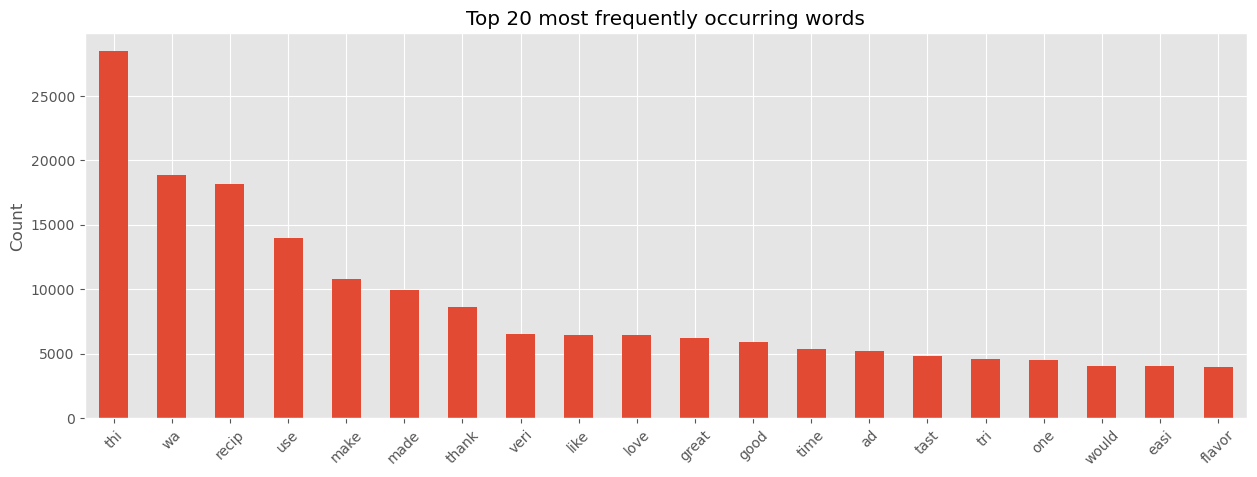

In [48]:
word_counts = pd.DataFrame(
    {"counts": X_train_sample_transformed.toarray().sum(axis=0)},
    index=bagofwords.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [49]:
# Fitting a model
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_sample_transformed, y_train_sample)

# Training and test score
print(f"Train score: {logreg.score(X_train_sample_transformed, y_train_sample)}")
print(f"Test score: {logreg.score(X_test_sample_transformed, y_test_sample)}")

Train score: 0.7965
Test score: 0.7612


C:\Users\ajgag\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


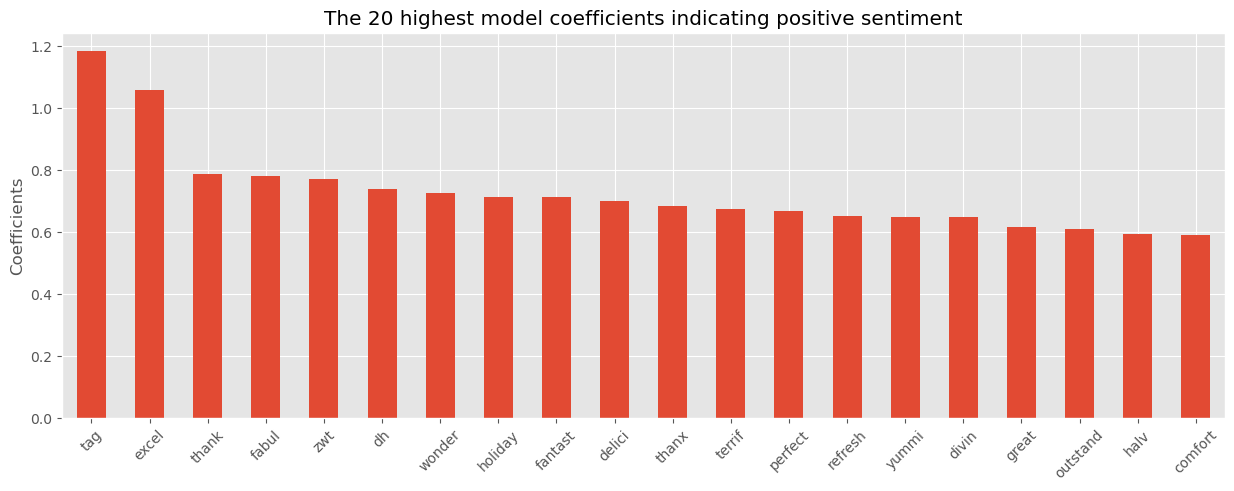

In [50]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bagofwords.get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

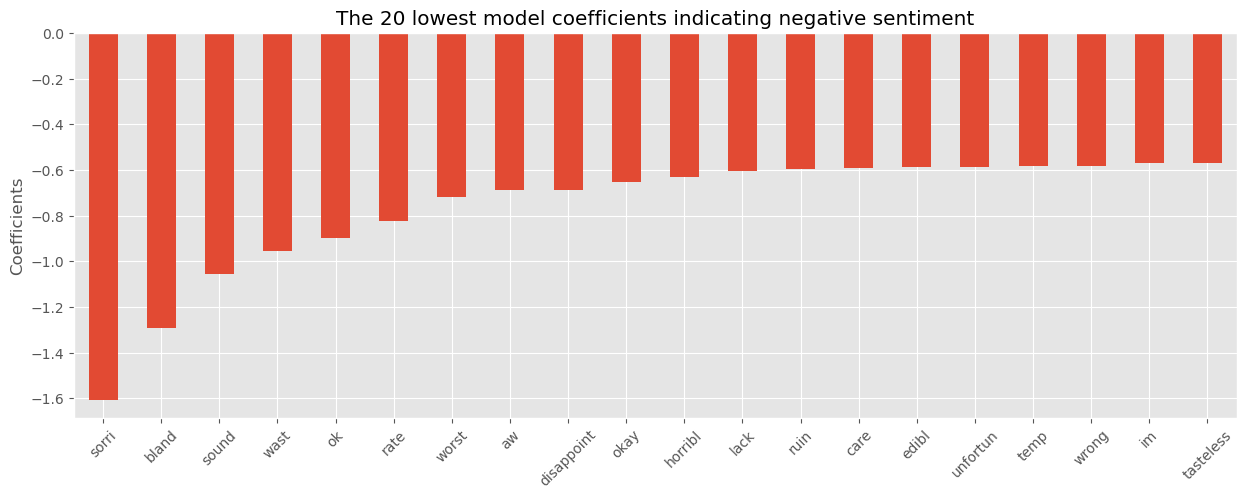

In [51]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [52]:
# Preprocess the new sentence
new_sentence = "wonderful I love it, its amazing"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
print(preprocessed_sentence)

#check recall , balance, confusion matrix, TIDF ---> different type (score based on how often they appear)
# check decision tree, knn, compre different models


['wonder', 'love', 'amaz']


In [61]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
# Preprocess the new sentence
new_sentence = "delicious"
new_sentece = str(new_sentence)

preprocessed_sentence = my_tokenizer(new_sentence)  # Applies the same preprocessing steps used for training
#preprocessed_sentence = ' '.join(preprocessed_sentence)  # Converts the list of tokens to a single string
# preprocessed not really working, have to update this
print(preprocessed_sentence)

new_sentence_transformed = bagofwords.transform([new_sentence])

print(logreg.predict(new_sentence_transformed))

['delici']
[0]


In [54]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])
print([preprocessed_sentence])
print(logreg.predict(new_sentence_transformed))

[['excel']]
[1]


In [55]:
# Transforms the preprocessed sentence using the trained CountVectorizer (bag of words)
new_sentence_transformed = bagofwords.transform([preprocessed_sentence[0]])


# Make a prediction on the transformed sentence using the trained logistic regression model
sentiment_prediction = logreg.predict(new_sentence_transformed)

# Interpret the prediction ... 1 would be something similar to a good rating (4 or 5 stars), while 0 would be a bad one
if sentiment_prediction == 1:
    print("The sentence has a positive sentiment.")
else:
    print("The sentence has a negative sentiment.")

The sentence has a positive sentiment.


Because of the data imbalance, it is always predicting Positive comments (since 90% of the data is positive) so I will wor in resampling to see if this solves the problem

In [56]:
# from sklearn.utils import resample

In [57]:
# print('Number of samples before:', X_train_sample_transformed.shape)

# print(X_test_sample_transformed.shape)
# X_upsampled, y_upsampled = resample(X_train_sample_transformed[y_train_sample == 1], 
#                                     y_train_sample[y_train_sample == 1], 
#                                     replace=True, 
#                                     n_samples= 50000, 
#                                     stratify = y_train_sample,
#                                     random_state=1)

# print('Number of samples afer:', X_upsampled.shape)

In [58]:
# questions to make
# should i make a decision tree for the recomendation? or knn or something with bayes?

# self note: do model evaluation, test True positives, false positive, true negative, false negative
# there is class imbalance so do model evaluation stuff
# i hae to do a value_counts to see how many i have of each rating to make a good resample
# use stratify , will pick samples in a smart way

In [59]:
# acurracy , precision, recall, confusion matrix
# ok i have to try different classifiers, hyperparameters (diffeerent c values, k values, which ones are performing the best)
# resample
# stratify
# create similar content to the text adata, how do we write code, expand on my own data.
# word cloud is ok


In [60]:
# try svm, hyper parameter, KNN, create pipelines ----> 
# ue counvectorizer or tfid... check ML pipelines.... 